# Facial expression Classification

# Preliminaries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import io
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Data from Kaggle

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"....","key":"......"}') # Your Kaggle username and key

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=7a75f0611ac2b4b2253521e51936a24a14f9af61eb5cb5b7759a413bd492e018
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [4]:
!kaggle datasets download -d msambare/fer2013

 99% 60.0M/60.3M [00:03<00:00, 23.6MB/s]
100% 60.3M/60.3M [00:03<00:00, 18.2MB/s]


In [5]:
# Extract dataset from the zip file
!unzip -q /content/fer2013.zip -d /content/data

array([[[ 46,  46,  46],
        [ 34,  34,  34],
        [ 26,  26,  26],
        ...,
        [ 10,  10,  10],
        [ 13,  13,  13],
        [ 22,  22,  22]],

       [[ 50,  50,  50],
        [ 28,  28,  28],
        [ 21,  21,  21],
        ...,
        [ 11,  11,  11],
        [ 10,  10,  10],
        [ 21,  21,  21]],

       [[ 50,  50,  50],
        [ 27,  27,  27],
        [ 15,  15,  15],
        ...,
        [ 22,  22,  22],
        [ 24,  24,  24],
        [ 22,  22,  22]],

       ...,

       [[208, 208, 208],
        [179, 179, 179],
        [108, 108, 108],
        ...,
        [191, 191, 191],
        [205, 205, 205],
        [204, 204, 204]],

       [[212, 212, 212],
        [198, 198, 198],
        [149, 149, 149],
        ...,
        [181, 181, 181],
        [200, 200, 200],
        [204, 204, 204]],

       [[208, 208, 208],
        [201, 201, 201],
        [171, 171, 171],
        ...,
        [165, 165, 165],
        [180, 180, 180],
        [189, 189, 189]]], dtype=uint8)
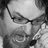

In [6]:
import cv2
im=cv2.imread('/content/data/test/angry/PrivateTest_10131363.jpg')
im

# Configs

In [7]:
config = {
    'batch_size': 64,  # Adjust based on GPU memory, can increase if GPU allows.
    'lr': 0.1,         # Learning rate for the optimizer
    'epochs': 100,      # Number of training epochs
    'rotation_angle': 15,
    'horizontal_flip': 0.5,
}

# Classification Dataset

In [8]:
DATA_DIR    = '/content/data'
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "test")



train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=config['rotation_angle']),
    torchvision.transforms.RandomHorizontalFlip(p=config['horizontal_flip']),
    torchvision.transforms.ToTensor()
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)

In [9]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False
)

In [10]:
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [11]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7
No. of train images  :  28709
Shape of image       :  torch.Size([3, 48, 48])
Batch size           :  64
Train batches        :  449
Val batches          :  113


## Data visualization

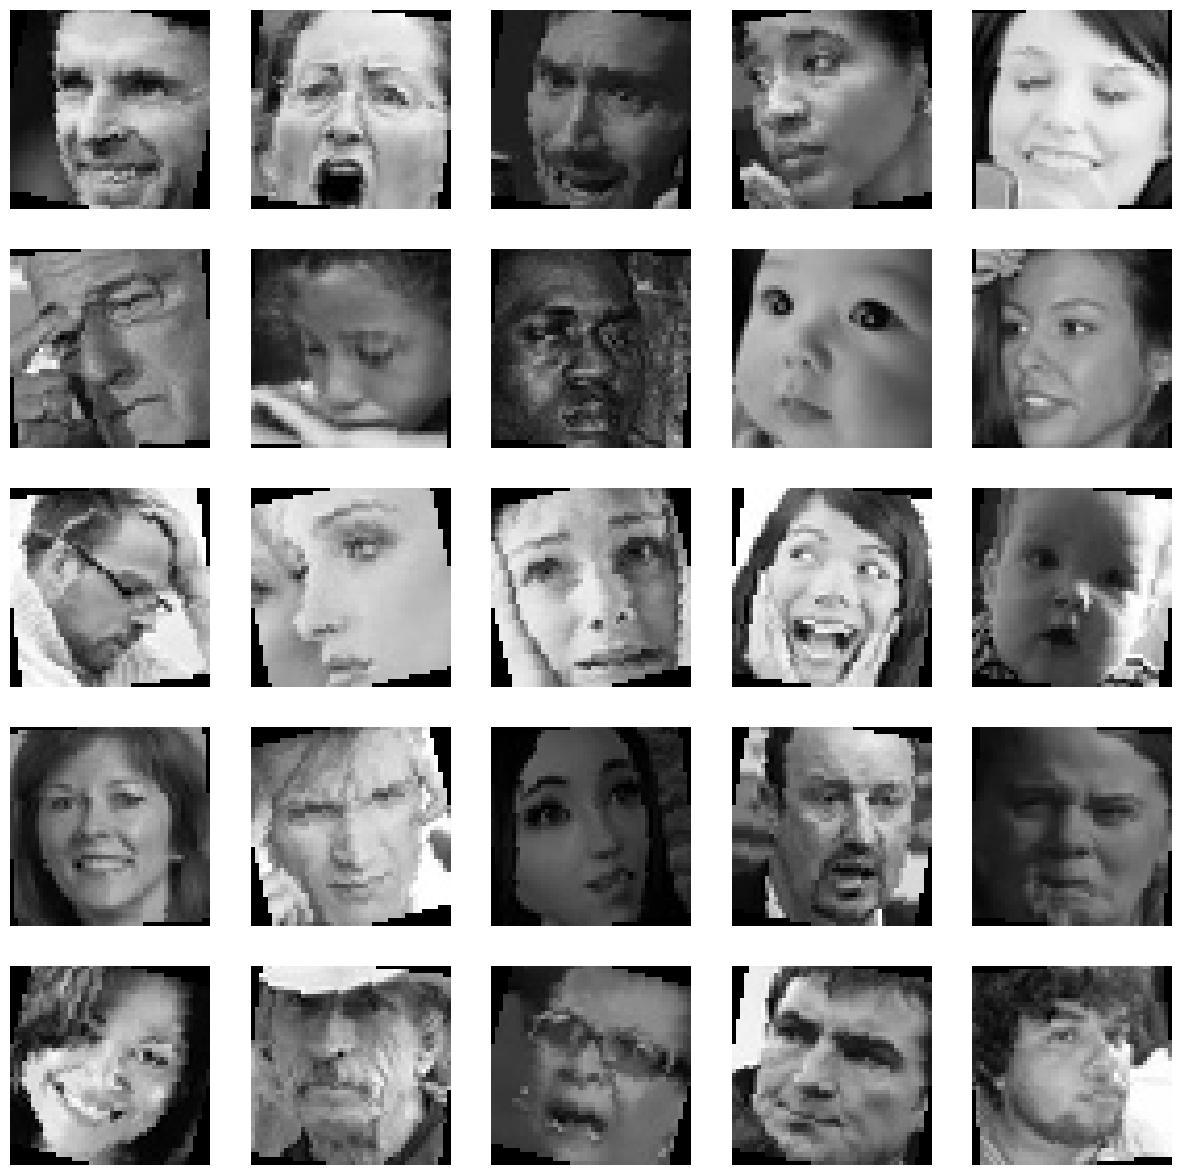

In [12]:
# Visualize a few images in the dataset
r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

## Model Architecture

In [13]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        out = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.unsqueeze(-1).unsqueeze(-1)
        return x * out

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SqueezeExcitationBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        # Adjust dimensions of residual if needed
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        super(SEResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global average pooling and fully-connected layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x, return_feats=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)

        if return_feats:
            return out, x
        else:
            return out

model = SEResNet(BasicBlock, [4, 5, 6, 2], num_classes=7).to(DEVICE)

In [14]:
def count_parameters(model=model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Model total parameters: {sum(params):>7}')

In [ ]:
count_parameters()

Model total parameters: 17067679


# Setup everything for training

In [15]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
# Lr Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.00004)

scaler = torch.cuda.amp.GradScaler() # FP16 (Mixed precision training) implemented 
# It is useful only in the case of compatible GPUs such as T4/V100

## Training

In [16]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad()

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # Mixed precision.
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # Close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [17]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [18]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Experiments

In [ ]:
!mkdir "/content/drive/MyDrive/FER2013"

In [19]:
checkpoints = torch.load('/content/drive/MyDrive/FER2013/checkpoint.pth')
model.load_state_dict(checkpoints['model_state_dict'])
optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
scheduler.load_state_dict(checkpoints['scheduler_state_dict'])


In [20]:
best_valacc = checkpoints['val_acc']
root = '/content/'

model_directory = os.path.join(root, "drive/MyDrive/FER2013")

for epoch in range(checkpoints['epoch']+1, config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # LR scheduler
    scheduler.step()

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
        path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
        print("Saving model")
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, path)
        best_valacc = val_acc


Epoch 61/100: 
Train Acc 72.0281%	 Train Loss 1.2215	 Learning Rate 0.0346


Val Acc 60.1770%	 Val Loss 1.4138



Epoch 62/100: 
Train Acc 74.0047%	 Train Loss 1.1924	 Learning Rate 0.0331


Val Acc 61.7257%	 Val Loss 1.3950
Saving model



Epoch 63/100: 
Train Acc 75.5429%	 Train Loss 1.1693	 Learning Rate 0.0316


Val Acc 62.3479%	 Val Loss 1.3887
Saving model



Epoch 64/100: 
Train Acc 77.2167%	 Train Loss 1.1461	 Learning Rate 0.0302


Val Acc 61.1034%	 Val Loss 1.4387



Epoch 65/100: 
Train Acc 78.3860%	 Train Loss 1.1288	 Learning Rate 0.0287


Val Acc 61.8916%	 Val Loss 1.4237



Epoch 66/100: 
Train Acc 79.1481%	 Train Loss 1.1140	 Learning Rate 0.0273


Val Acc 61.3800%	 Val Loss 1.4315



Epoch 67/100: 
Train Acc 80.1573%	 Train Loss 1.0989	 Learning Rate 0.0259


Val Acc 61.9054%	 Val Loss 1.4190



Epoch 68/100: 
Train Acc 81.5841%	 Train Loss 1.0786	 Learning Rate 0.0246


Val Acc 61.9331%	 Val Loss 1.4373



Epoch 69/100: 
Train Acc 82.4819%	 Train Loss 1.0640	 Learning Rate 0.0232


Val Acc 61.0619%	 Val Loss 1.4647



Epoch 70/100: 
Train Acc 83.4424%	 Train Loss 1.0482	 Learning Rate 0.0219


Val Acc 60.5503%	 Val Loss 1.4686



Epoch 71/100: 
Train Acc 84.1801%	 Train Loss 1.0343	 Learning Rate 0.0206


Val Acc 62.7627%	 Val Loss 1.4469
Saving model



Epoch 72/100: 
Train Acc 85.6417%	 Train Loss 1.0089	 Learning Rate 0.0194


Val Acc 62.2788%	 Val Loss 1.4716



Epoch 73/100: 
Train Acc 86.6718%	 Train Loss 0.9977	 Learning Rate 0.0182


Val Acc 61.7395%	 Val Loss 1.4665



Epoch 74/100: 
Train Acc 87.8619%	 Train Loss 0.9773	 Learning Rate 0.0170


Val Acc 63.2190%	 Val Loss 1.4631
Saving model



Epoch 75/100: 
Train Acc 88.5301%	 Train Loss 0.9656	 Learning Rate 0.0158


Val Acc 62.2649%	 Val Loss 1.4852



Epoch 76/100: 
Train Acc 89.1947%	 Train Loss 0.9523	 Learning Rate 0.0147


Val Acc 62.8457%	 Val Loss 1.4581



Epoch 77/100: 
Train Acc 90.1308%	 Train Loss 0.9366	 Learning Rate 0.0136


Val Acc 62.1543%	 Val Loss 1.4943



Epoch 78/100: 
Train Acc 91.0461%	 Train Loss 0.9249	 Learning Rate 0.0125


Val Acc 62.7074%	 Val Loss 1.4759



Epoch 79/100: 
Train Acc 91.9404%	 Train Loss 0.9067	 Learning Rate 0.0115


Val Acc 61.9884%	 Val Loss 1.5175



Epoch 80/100: 
Train Acc 92.5251%	 Train Loss 0.8973	 Learning Rate 0.0105


Val Acc 63.2467%	 Val Loss 1.5026
Saving model



Epoch 81/100: 
Train Acc 93.2210%	 Train Loss 0.8855	 Learning Rate 0.0096


Val Acc 62.9010%	 Val Loss 1.5104



Epoch 82/100: 
Train Acc 93.8405%	 Train Loss 0.8749	 Learning Rate 0.0087


Val Acc 63.6753%	 Val Loss 1.5032
Saving model



Epoch 83/100: 
Train Acc 94.4495%	 Train Loss 0.8635	 Learning Rate 0.0078


Val Acc 63.4264%	 Val Loss 1.5134



Epoch 84/100: 
Train Acc 94.9784%	 Train Loss 0.8565	 Learning Rate 0.0070


Val Acc 63.7445%	 Val Loss 1.5104
Saving model



Epoch 85/100: 
Train Acc 95.5039%	 Train Loss 0.8447	 Learning Rate 0.0062


Val Acc 64.0763%	 Val Loss 1.5074
Saving model



Epoch 86/100: 
Train Acc 95.9981%	 Train Loss 0.8373	 Learning Rate 0.0055


Val Acc 63.7445%	 Val Loss 1.5316



Epoch 87/100: 
Train Acc 96.3008%	 Train Loss 0.8328	 Learning Rate 0.0048


Val Acc 64.5326%	 Val Loss 1.5200
Saving model



Epoch 88/100: 
Train Acc 96.8785%	 Train Loss 0.8226	 Learning Rate 0.0042


Val Acc 64.2423%	 Val Loss 1.5311



Epoch 89/100: 
Train Acc 97.0908%	 Train Loss 0.8190	 Learning Rate 0.0035


Val Acc 63.8274%	 Val Loss 1.5394



Epoch 90/100: 
Train Acc 97.4248%	 Train Loss 0.8117	 Learning Rate 0.0030


Val Acc 63.6753%	 Val Loss 1.5410



Epoch 91/100: 
Train Acc 97.6371%	 Train Loss 0.8077	 Learning Rate 0.0025


Val Acc 63.7168%	 Val Loss 1.5532



Epoch 92/100: 
Train Acc 97.7589%	 Train Loss 0.8059	 Learning Rate 0.0020


Val Acc 63.9104%	 Val Loss 1.5483



Epoch 93/100: 
Train Acc 98.0686%	 Train Loss 0.8009	 Learning Rate 0.0016


Val Acc 63.9795%	 Val Loss 1.5490



Epoch 94/100: 
Train Acc 98.2287%	 Train Loss 0.7980	 Learning Rate 0.0012


Val Acc 63.9104%	 Val Loss 1.5513



Epoch 95/100: 
Train Acc 98.2739%	 Train Loss 0.7981	 Learning Rate 0.0009


Val Acc 63.9795%	 Val Loss 1.5540



Epoch 96/100: 
Train Acc 98.2217%	 Train Loss 0.7968	 Learning Rate 0.0007


Val Acc 64.1455%	 Val Loss 1.5506



Epoch 97/100: 
Train Acc 98.3192%	 Train Loss 0.7967	 Learning Rate 0.0004


Val Acc 63.9934%	 Val Loss 1.5523



Epoch 98/100: 
Train Acc 98.3679%	 Train Loss 0.7951	 Learning Rate 0.0003


Val Acc 64.2561%	 Val Loss 1.5526



Epoch 99/100: 
Train Acc 98.3609%	 Train Loss 0.7959	 Learning Rate 0.0001


Val Acc 64.0625%	 Val Loss 1.5529



Epoch 100/100: 
Train Acc 98.4584%	 Train Loss 0.7940	 Learning Rate 0.0001


Val Acc 64.1731%	 Val Loss 1.5546


### Load Model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FER2013/checkpoint.pth')['model_state_dict'])